# Thomeer-Used-to-Model-High-Pressure-Mercury-Injection-Data
In this repository we provide the python code used to Closure correct and model High Pressure Mercury Injection (HPMI) data using the Thomeer hyperbola.

## Introduction:
This GitHub repository uses python code to import High Pressure Mercury Injection (HPMI) Core data fron Excel and then use a Thomeer hyperbola to model the Thomeer Capillary Pressure parameters as shown below. Ed Clerke used a similar method in Excel with Solver to estimate his Thomeer parameters for each HPMI sample that went into the Rosetta Stone Arab D Carbonate Thomeer database. His Excel spreadsheet is readily available, and we will included as copy of this spreadsheet in this repository. We also used fminsearch in Matlab too. We have used these types of software to establish our own Reservoir Characterization Reservoir-Specific core calibration databases in the past for a reservoir-specific studies.

![HPMI_Image](HPMI.png)

## How it Works:
The following animated image illustrates how this software operates. We start with the original HPMI data. The first step is to locate the point on the HPMI curve that represents the point where real data begins and not the HPMI data representing surface conformance around the plug sample. We also select the Initial Displacement Pressure (Pd1) for the sample for the first pore system too. We find that most carbonate rocks have bi-modal pore throat distributions representing two pore systems as shown in the example below. The selection of this point is performed with just a click on the Graphical User Interface (GUI) where this occurs. 

For the second step we pick the point for the Bulk Volume porosity of the first pore system (BV1) as well as the Initial Displacement Pressure for the second pore system (Pd2).

The third step is to select the Total porosity for the HPMI data called BVtotal where the porosity of the second pore system is called BV2:

              BV2 = BVtotal - BV1

![HPMI_Image](Thomeer_Parameter_fitting.gif)

This program uses Scipy Optimize Curve_fit to estimate the appropriate Thomeer parameters necessary to model the HPMI data. The points selected from the GUIs are used to estimate boundary conditions for these estimations, and the estimations for this example are shown below:

            Thomeer Parameters Estimated from Imported HPMI Data:
            Pd1 = 8.67  ,  G1 = 0.54 , BV1 = 10.13
            Pd2 = 389.1 ,  G2 = 0.24 , BV2 = 4.8


## Reservoir Characterization Workflow:
We are using the HPMI data from just one sample for this example. Our objective will be to employ this program in Geolog as a python loglan. In Geolog we will read the Pc data in from the SCAL data stored in a well and write the results for each sample back to Geolog to build our sample-by-sample core calibration database. We would then use the carbonate characterization workflow as employed in our following GitHub repository but alter the workflow to employ our own new reservoir-specific calibration data for our reservoir characterization.

https://github.com/Philliec459/Geolog-Used-to-Automate-the-Characterization-Workflow-using-Clerkes-Rosetta-Stone-calibration-data

In the above workflows we have used hundreds of HPMI samples as calibration. In the image below we are showing the Porosity vs. Permeability cross plot in the upper left for all the calibration samples used for the Arab D reservoir; all colored by Petrophysical Rock Type. We select a small group of poro-perm samples, and the Pc curves from this small group of selected samples is then shown in the lower left. The black Pc curve is the upscaled Pc curve from the selected samples, and the black bars in the histograms are the median value for the selected samples. We would be using upscaled Pc curves that varies level by level in the well to model saturations because of the changing reservoir quality along the wellbore.

![Thomeer_Pc_and_Thomeer_Parameters.gif](Thomeer_Pc_and_Thomeer_Parameters2.gif)

## Modeling of Saturations Using Thomeer Capillary Pressure Parameters: 
Also, the following image shows one example from our modeling of saturations from Capillary Pressure vs. log analysis. The match is very good. I personally have performed this type of characterization on at least 30 huge carbonate oil fields in Saudi, and the results shown below are very typical.

![HPMI_Image](logsats.gif)

1 Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October, 2008.

# Requirements:
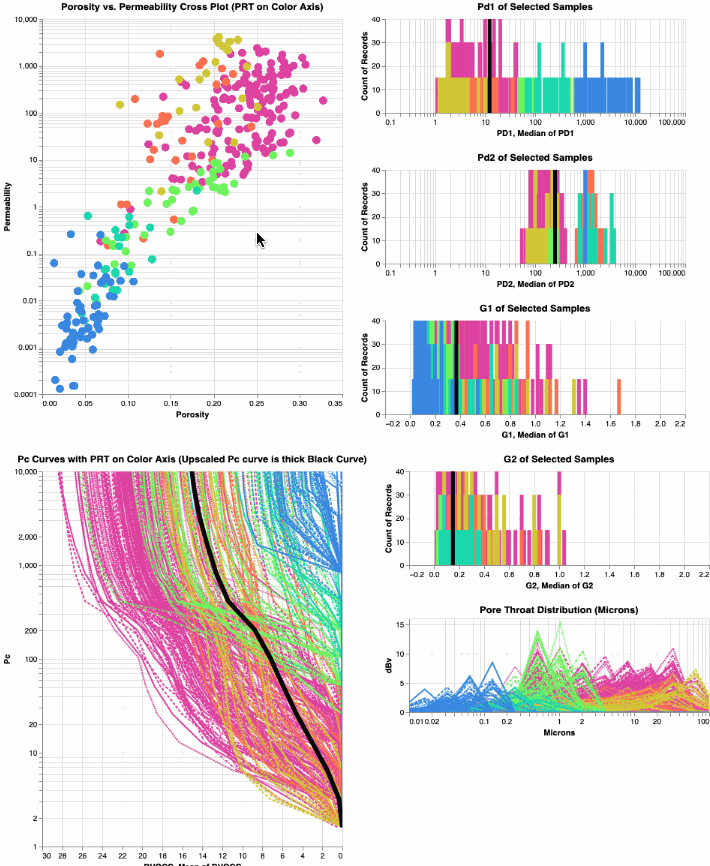

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 27 09:50:53 2019

@author: craig phillips
"""
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget, QPushButton
#from PyQt5.QtCore import QTimer
#******************************************************************
#%matplotlib inline
#%matplotlib notebook
%matplotlib qt


import matplotlib

import matplotlib.pyplot as plt
matplotlib.use("Qt5Agg")
import matplotlib.gridspec as gridspec
#******************************************************************
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

import numpy as np
import pandas as pd
from numpy import diff
import openpyxl



# GUI Input or Pc data for Closure Correction and Thomeer Estimates of BV1, Pd1, Pd2 and BVtotal:

### Read in Pc data from xlsx file of Pc vs. BVocc:

In [2]:
# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #                Read Pc Data Spreadsheet 
# # #  
# # #             
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
#read the file
#file = r'Pc_data_fmin.xlsx'
file = r'./data/Pc_data_dual_porosity.xlsx'

Thomeer_Pc_data = pd.read_excel(file,index_col=False)

Pc_r = Thomeer_Pc_data['Pc']
BVocc_r = Thomeer_Pc_data['BVocc']

x_Pc=np.array(BVocc_r)
y_Pc=np.array(Pc_r)
# =============================================================================
# # ===========================================================================
# # #------------------------------------------------------------ 
# # #               
# # #     End of reading in Pc data
# # #------------------------------------------------------------
# # ===========================================================================
# =============================================================================

## How many Pore Systems are we dealing with for this sample? 
In Geolog this is read in automatically from a curve called NO_PORE_SYS:

In [3]:
# for Excel file you need to add the number of pore systems below:
no_pore_sys= 2

## Try to use the Pore Throat Distribution (PTD) to pick the Closure Correction:

In [4]:
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            Graphical Use of PTD to select Closure Currection 
# ##
# # #--------------------------------------------------------------------------
# =============================================================================
# =============================================================================
# =============================================================================
#             Graphical Input for Closure Correction and Pd1 
# =============================================================================

#Calculate rate of change 
diffx0 = np.diff(BVocc_r)
diffx  = np.hstack((0, diffx0*10))

diffy0 = np.diff(Pc_r)
diffy  = np.hstack((0, diffy0*10))


def tellme(s):
    print(s)
    plt.title(s, fontsize=16, fontweight="bold", color = 'red')
    plt.draw()


plt.clf()   #clear plot of other things

plt.figure(num=2, figsize=(10, 10))
#plt.ion()
#plt.semilogx(diffy, diffx  , 'r-', linewidth=3, label='HPMI Pore Throat Distribution of Raw Data' )
plt.semilogx(BVocc_r, diffx  , 'r-', linewidth=3, label='HPMI Pore Throat Distribution of Raw Data' )

plt.xlabel('BVocc', color = 'red', fontsize=12, fontweight="bold")
plt.ylabel('Delta BVocc',    color = 'red', fontsize=12, fontweight="bold")
#plt.xlim( 100000, 0.1)
plt.xlim( 100, 0.01)

plt.ylim(0.0, 10)
plt.grid(True, which="both",ls="-")
plt.legend()

#Use pts array to store selected points
pts = []

while len(pts) < 1:
    tellme('Select Closure Correction from PTD (Not Implemented Yet)')
    pts = np.asarray(plt.ginput(1, timeout=3))

Closure_PTD = pts.item(1)
Junk_ptd    = pts.item(0)

print()
print('Closure Correction from PTD =', round(Closure_PTD,2) )
print()

plt.close('all')
# =============================================================================
#             End of Graphical Input for Closure Correction
# =============================================================================


Select Closure Correction from PTD (Not Implemented Yet)

Closure Correction from PTD = 1.77



## Select the single point Closure Correction and Pd1 Thomeer Estimate from GUI:

In [5]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            Graphical Input of Closure Correction and Pd1 
# ##
# # #--------------------------------------------------------------------------
# =============================================================================
# =============================================================================
# =============================================================================
#             Graphical Input for Closure Correction and Pd1 
# =============================================================================
def tellme(s):
    print(s)
    plt.title(s, fontsize=16, fontweight="bold", color = 'green')
    plt.draw()


plt.clf()   #clear plot of other things

plt.figure(num=2, figsize=(10, 10))
#plt.ion()
plt.semilogy(x_Pc, y_Pc  , 'g-*', linewidth=1, label='HPMI Data' )
plt.semilogy(Closure_PTD, 2  , 'r-o', linewidth=3, label='Closure Correction from PTD' )
plt.xlabel('BVocc', color = 'green', fontsize=12, fontweight="bold")
plt.ylabel('Pc',    color = 'green', fontsize=12, fontweight="bold")
plt.xlim(30.0, 0.0)
plt.ylim(1, 100000)
plt.grid(True, which="both",ls="-")
plt.legend()

#Use pts array to store selected points
pts = []

while len(pts) < 1:
    tellme('Select Closure Correction and Pd1')
    pts = np.asarray(plt.ginput(1, timeout=3))

Closure = pts.item(0)
Pd1 = pts.item(1)

print()
print('Closure Correction =', round(Closure,2), ' and Pd1 =', round(Pd1,1))
print()

plt.close('all')
# =============================================================================
#             End of Graphical Input for Closure Correction and Pd1 
# =============================================================================

Select Closure Correction and Pd1

Closure Correction = 1.43  and Pd1 = 13.9



## Closure Correct the BVocc array from our Pc data:
Most HPMI data has issues in the low pressure regime with the mercruy conforming around the plug sample. We need to remove this early data because this is not matrix. This is called a Closure Correction. 

In [6]:
# =============================================================================
#           Closure Correction of Pc data
# =============================================================================
x_Pc_nocc = np.array(BVocc_r)
for i in range(0,len(Thomeer_Pc_data),1):
    
    BVocc_r[i]=BVocc_r[i]-Closure
    
    if BVocc_r[i] < 0:
        BVocc_r[i] = 0.001
    else:
        BVocc_r[i] = BVocc_r[i]

x_Pc=np.array(BVocc_r)
#print(x_Pc_nocc)
#print(x_Pc)
# =============================================================================
#          End of Closure Correction for Pc data
# =============================================================================


## Select a single point for BV1 & Pd2 Thomeer parameter estimates directly from the GUI:

In [7]:
# =============================================================================
#             Graphical Input for Pd2 and BV1
# =============================================================================
def tellme(s):
    print(s)
    plt.title(s, fontsize=16, fontweight="bold", color = 'blue')
    plt.draw()

plt.clf()   #clear plot of other things

plt.figure(num=2, figsize=(10, 10))

plt.loglog(x_Pc, y_Pc  , 'b-*', linewidth=1, label='HPMI Data' )
plt.loglog(Closure, Pd1  , 'k-o', linewidth=1, label='Closure Correction and Pd1 Estimate' )
plt.loglog(Closure_PTD, Pd1  , 'r-o', linewidth=3, label='Closure Correction from PTD' )
plt.xlabel('BVocc',color = 'blue', fontsize=12, fontweight="bold")
plt.ylabel('Pc',color = 'blue', fontsize=12, fontweight="bold")
plt.xlim(50.0,0.1)
plt.ylim(1, 100000)
plt.grid(True, which="both",ls="-")
plt.legend()

pts = []


while len(pts) < 1:
    tellme('Select BV1 and Pd2')
    pts = np.asarray(plt.ginput(1, timeout=3))

BV1 = pts.item(0)
Pd2 = pts.item(1)

print()
print('BV1 =', round(BV1,2), ' and Pd2 =', round(Pd2,1))
print()

plt.close('all')  
# =============================================================================
#             End of Graphical Input for Pd2 and BV1
# =============================================================================

Select BV1 and Pd2

BV1 = 6.22  and Pd2 = 367.2



## Select the single point for BVtotal from GUI if you have over two pore systems:
This is the asymtote of the Pc curve in the last pore system. 

In [8]:
# =============================================================================
#             Graphical Input for BVtotal
# =============================================================================
if no_pore_sys > 1: 
    def tellme(s):
        print(s)
        plt.title(s, fontsize=16, fontweight="bold", color = 'red')
        plt.draw()
    
    plt.clf()   #clear plot of other things
    
    plt.figure(num=2, figsize=( 10, 10))
    
    plt.loglog(x_Pc, y_Pc  , 'r-*', linewidth=1, label='HPMI Data' )
    plt.loglog(Closure, Pd1  , 'k-o', linewidth=1, label='Closure Correction and Pd1 Estimate' )
    plt.loglog(Closure_PTD, Pd1  , 'r-o', linewidth=3, label='Closure Correction from PTD' )
    plt.loglog(BV1, Pd2  , 'k-o', linewidth=1, label='BV1 and Pd2 Estimate' )
    plt.xlabel('BVocc',color = 'red', fontsize=12, fontweight="bold")
    plt.ylabel('Pc',color = 'red', fontsize=12, fontweight="bold")
    plt.xlim(50.0,0.01)
    plt.ylim(1, 100000)
    plt.grid(True, which="both",ls="-")
    plt.legend()
    
    #Use pts array to store selected points
    pts = []
    
    
    while len(pts) < 1:
        tellme('Select BVtotal')
        pts = np.asarray(plt.ginput(1, timeout=3))
    
    BVtotal = pts.item(0)
    junk = pts.item(1)
    
    BV2 = BVtotal - BV1
    print('BV2 = ',BV2)

    G2=0.2
    
    print()
    print('BVtotal =', round(BVtotal,2))
    print()
    
    
    plt.close('all')  
# =============================================================================
#             End of Graphical Input of BVtotal
# =============================================================================

Select BVtotal
BV2 =  3.723398697158051

BVtotal = 9.94



## We use Scipy Curve_Fit to Estimate the Thomeer Capillary Pressure Parameters:

In [9]:
# =============================================================================
#             Scipy for Curve_fit of Pd1, G1 and BV1
# =============================================================================
from scipy.optimize import curve_fit
quality  = "BAD FIT"
# =============================================================================
#             Scipy for Curve_fit for just Pd1, G1 and BV1
# =============================================================================

if no_pore_sys == 1: 

    bvarray_pore1 = []; #make list of 0 length
    pcarray_pore1 = []

    for i in range(1, 115, 1):
        if Pc_r[i] > Pd1 and Pc_r[i] < Pd2 :
            BVOCC = (BVocc_r[i])

            bvarray_pore1.append(BVocc_r[i]); #add items 
            pcarray_pore1.append(Pc_r[i]); #add items     


    ydata=np.array(bvarray_pore1)
    xdata=np.array(pcarray_pore1)

    def func(xdata, a, b, c):
        return a*10**((-0.434*b)/np.log10(xdata/c))


    # No exception Exception raised in try block
    try:
        popt, pcov = curve_fit(func, xdata, ydata, method='trf', bounds=([1.0, 0.1, 1. ], [np.inf, np.inf, np.inf]))

        BV1_solve = popt[0]   
        G1_solve  = popt[1]
        Pd1_solve = popt[2]
        quality  = "GOOD FIT"
        print()
        print('Good Curve Fit for Pore System 1, and only 1 Pore System',', Quality =',quality)
        print()
        print()
        print('      Pd1 pick =',round(Pd1,1),', G1 or popt[1] =',round(popt[1],2),',       BV1 pick =',round(BV1,2))
        print('Pd1 or popt[2] =',round(Pd1_solve,1),', G1 or popt[1] =',round(G1_solve,3),', BV1 or popt[0] =',round(BV1_solve,2))
        print()

    # handles issues  
    except :
        # this block is always executed 
        quality  = "BAD FIT"
        BV1_solve = BV1   
        G1_solve  = .51
        Pd1_solve = Pd1
        # regardless of exception generation.
        print() 
        print('Bad Curve Fit for Pore System 1, and only 1 Pore System',', Quality =',quality)
        print()
        print('Pd1 pick =',round(Pd1,1),', G1 - assigned as 0.51???',',       BV1 pick =',round(BV1,2))
        print()




    Pd2_solve = float("nan")
    G2_solve  = float("nan")
    BV2_solve = float("nan")

    BVtotal = BV1_solve 

    # =============================================================================
    #             Create Pc Curves for curve fit Thomeer parameters
    # =============================================================================
    Pc = 0.5
    bvarray_pred = []; #make list of 0 length
    pcarray_pred = []

    for j in range(1, 105, 1):
        if Pc > Pd1_solve:
            BVOCC1 = BV1_solve * 10**((-0.434 * G1_solve) / np.log10(Pc / Pd1_solve))
        else:
            BVOCC1 = 0.001


        BVOCC = BVOCC1

        bvarray_pred.append(BVOCC); #add items 
        pcarray_pred.append(Pc); #add items 

        Pc = Pc * 1.12


    x_solve=np.array(bvarray_pred)
    y_solve=np.array(pcarray_pred)

# =============================================================================
#             Scipy for Curve_fit of 2 Pore Systems
# =============================================================================
elif no_pore_sys == 2  :

    bvarray_pore1 = []; #make list of 0 length
    pcarray_pore1 = []

    for i in range(1, 115, 1):
        if Pc_r[i] > Pd1 and Pc_r[i] < Pd2 :
            BVOCC = (BVocc_r[i])

            bvarray_pore1.append(BVocc_r[i]); #add items 
            pcarray_pore1.append(Pc_r[i]); #add items     

    ydata=np.array(bvarray_pore1)
    xdata=np.array(pcarray_pore1)

    def func1(xdata, a, b, c):
        return a*10**((-0.434*b)/np.log10(xdata/c))

     # No exception Exception raised in try block
    try:
        popt, pcov = curve_fit(func1, xdata, ydata, method='trf', bounds=([1.0, .1, 1.0 ], [np.inf, np.inf, np.inf]))

        BV1_solve = popt[0]   
        G1_solve  = popt[1]
        Pd1_solve = popt[2]
        quality = "GOOD FIT"
        print()
        print('Good Curve Fit for Pore System 1 of 2 Pore Systems',', Quality =',quality)
        print()
        print('      Pd1 pick =',round(Pd1,1),', G1 or popt[1] =',round(popt[1],2),',       BV1 pick =',round(BV1,2))
        print('Pd1 or popt[2] =',round(Pd1_solve,1),', G1 or popt[1] =',round(G1_solve,2),', BV1 or popt[0] =',round(BV1_solve,2))
        print()



    # handles issues  
    except :
        # this block is always executed 
        quality  = "BAD FIT"
        BV1_solve = BV1   
        G1_solve  = .49
        Pd1_solve = Pd1
        # regardless of exception generation.
        print() 
        print('Bad Curve Fit for Pore System 1 of 2 Pore Systems',', Quality =',quality)
        print()
        print()
        print('Pd1_solve  =',round(Pd1_solve,1),', G1_solve =',round(G1_solve,2),', BV1_solve =',round(BV1_solve,2))
        print()





    # =============================================================================
    #             Scipy for Curve_fit of Pd2, G2 and BV2
    # =============================================================================
    bvarray_pore2 = []; #make list of 0 length
    pcarray_pore2 = []

    for i in range(1, 115, 1):
        if Pc_r[i] > Pd2 :

            BVOCC = (BVocc_r[i])

            bvarray_pore2.append(BVocc_r[i]); #add items 
            pcarray_pore2.append(Pc_r[i]); #add items     


    ydata2=np.array(bvarray_pore2)
    xdata2=np.array(pcarray_pore2)

    def func2(xdata2, a, b, c):
        return a*10**((-0.434*b)/np.log10(xdata2/c))

    #popt, pcov = curve_fit(func2, xdata2, ydata2, method='dogbox', bounds=([0.0 , 0.1, 1.0 ], [np.inf, np.inf, np.inf]))    

    # No exception Exception raised in try block
    try:
        popt, pcov = curve_fit(func2, xdata2, ydata2, method='dogbox', bounds=([0.0 , 0.1, 1.0 ], [np.inf, np.inf, np.inf])) 
        print()
        print('Good Curve Fit for Pore System 2 of 2 Pore Systems',', Quality =',quality)

        #BV2_solve = popt[0] - BV1_solve
        if  popt[0] - BV1_solve > 0:
            BV2_solve = popt[0] - BV1_solve   
        else:
            BV2_solve = 0       

        G2_solve  = popt[1]
        #Pd2_solve = popt[2]
        Pd2_solve = Pd2
        quality  = "GOOD FIT"
        print()
        print('Pd2_solve  =',round(Pd2_solve,1),', G2_solve =',round(G2_solve,2),', BV2_solve =',round(BV2_solve,2))
        print()



    # handles issues  
    except :
        # this block is always executed 
        BV2_solve = BV2   
        G2_solve  = .48
        Pd2_solve = Pd2
        quality  = "BAD FIT"
        # regardless of exception generation.
        print() 
        print('Bad Curve Fit for Pore System 2 of 2 Pore Systems',', Quality =',quality)
        print()
        print('Pd2  =',round(Pd2_solve,1),', G2 or popt[1] =',round(G2_solve,2),', BV2 or popt[0] =',round(BV2_solve,2))
        print()



    # =============================================================================
    #             Create Pc Curves for curve fit Thomeer parameters
    # =============================================================================
    Pc = 0.5
    bvarray_pred = []; #make list of 0 length
    pcarray_pred = []
    bvocc2_pred  = []

    for j in range(1, 105, 1):
        if Pc > Pd1_solve:
            BVOCC1 = BV1_solve * 10**((-0.434 * G1_solve) / np.log10(Pc / Pd1_solve))
        else:
            BVOCC1 = 0.001

        if Pc > Pd2_solve:
            BVOCC2 = BV2_solve * 10**((-0.434 * G2_solve) / np.log10(Pc / Pd2_solve))
        else:
            BVOCC2 = 0.001


        BVOCC = BVOCC1 + BVOCC2

        bvarray_pred.append(BVOCC); #add items 
        pcarray_pred.append(Pc); #add items 
        bvocc2_pred.append(BVOCC2)  

        Pc = Pc * 1.12


    x_solve=np.array(bvarray_pred)
    x2_solve=np.array(bvocc2_pred)
    y_solve=np.array(pcarray_pred)
    # =============================================================================
    #             End of Scipy for Curve_fit of Pd1, G1 and BV1
    # =============================================================================



Good Curve Fit for Pore System 1 of 2 Pore Systems , Quality = GOOD FIT

      Pd1 pick = 13.9 , G1 or popt[1] = 0.46 ,       BV1 pick = 6.22
Pd1 or popt[2] = 10.8 , G1 or popt[1] = 0.46 , BV1 or popt[0] = 8.43


Good Curve Fit for Pore System 2 of 2 Pore Systems , Quality = GOOD FIT

Pd2_solve  = 367.2 , G2_solve = 0.46 , BV2_solve = 3.86



# This section for creating a header and saving Thomeer parameters for a file is work in progress. 

In [10]:
#df = pd.read_excel('YourExcel.xlsx', sheet_name=None)
#df['worksheet_name'].to_csv('output.csv')  
#data_xls = pd.read_excel('excelfile.xlsx', 'Sheet2', dtype=str, index_col=None)




#data_xls.to_csv('csvfile.csv', encoding='utf-8', index=False)


In [11]:

#Thomeer_export = []
#Thomeer_export = pd.DataFrame({'Pd1',Pd1_solve,'G1',G1_solve,'BV1',BV1_solve, 'Pd2',Pd2_solve,'G2',G2_solve,'BV2',BV2})

#data_xls.to_csv('csvfile.csv', encoding='utf-8', index=False)


#name_dict = {
#            'Thomeer Parameters': ['Pd1','G1','BV1','Pd2','G2','BV2'],
#            'Values': [Pd1_solve,G1_solve,BV1_solve,Pd2_solve,G2_solve,BV2]
#          }

#newthomeer = pd.DataFrame(name_dict)

#newthomeer.to_csv('./data/Thomeer_results.csv', float_format='%.2f', encoding='utf-8', index=False)

#print (newthomeer)


In [12]:
#filename = 'C:\\temp\\spreadsheet.xlsx'
#wb = openpyxl.load_workbook(filename=filename)
#sheet = wb['Sheet1']
#new_row = 'Thomeer'['column1', 'column2', 'column3']

#sheet.append(new_row)
#wb.save(filename)

## Header line placed in saved data:
#### Move past this section if you already have a header in the stored Excel file; however, you need this excel file to exist or error message. 

In [13]:
filename = './data/Thomeer_results.xlsx'
wb = openpyxl.load_workbook(filename=filename)
sheet = wb['Sheet1']
header = ['Pd1', 'G1', 'BV1', 'Pd2', 'G2', 'BV2']

sheet.append(header)

wb.save(filename)

## Write Thomeer parameter results to file:

In [14]:
filename = './data/Thomeer_results.xlsx'
wb = openpyxl.load_workbook(filename=filename)
sheet = wb['Sheet1']
new_row = [Pd1_solve, G1_solve, BV1_solve, Pd2_solve, G2_solve, BV2_solve]

sheet.append(new_row)

wb.save(filename)

## This is the final Plot widget that shows a summary of the original Pc curve, the Closure Corrected Pc curve and the final Pc curve from the estimated Thomeer parameters with Thomeer parameters:

In [15]:
# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #                
# # #               Qt GUI Plots made here
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#Define Canvas
class App(QMainWindow):

    def __init__(self):
        super().__init__()
        self.left = 50
        self.top = 100
        self.title = 'Carbonate Petrophysical Analysis'
        self.width = 1000
        self.height = 1000
        self.initUI()




    #Define Canvas and Pushbutton
    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(self.left, self.top, self.width, self.height)

        # this defines the width and height of canvas 
        m = PlotCanvas(self, width=10, height=10)
        m.move(0,0)



        button = QPushButton('Please use this button to Quit Window', self)
        button.setDefault(True)
        button.setToolTip('Push this button to quit')
        #Botton starts at 500 and 0
        button.move(400,0)
        #Botton starts at 500 and goes +140 to 640 to cover canvas
        button.resize(300,30)

#        def on_button_clicked():
#            alert = QMessageBox()
#            alert.setText('You clicked the button!')
#            alert.exec_()
        def on_button_clicked():
            sys.exit(app.exec_())



        button.clicked.connect(on_button_clicked)


        self.show()


class PlotCanvas(FigureCanvas):

#what is this???
    def __init__(self, parent=None, width=5, height=5, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
#            self.axes = fig.add_subplot(211)  apparently not needed now

        FigureCanvas.__init__(self, fig)
        self.setParent(parent)

        FigureCanvas.setSizePolicy(self,
                QSizePolicy.Expanding,
                QSizePolicy.Expanding)
        FigureCanvas.updateGeometry(self)
        
        self.plot()
        #self.plot2()
        #self.plot3()
        #self.plot4()


# Pc Plot across top 0 to 3
    def plot(self):

        gs = gridspec.GridSpec(nrows=3, 
                               ncols=3, 
#                               figure=fig, 
                               width_ratios= [1, 1, 1],
                               height_ratios=[1, 1, 1],
                               wspace=0.3,
                               hspace=0.3)
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots 

        
        ax = self.figure.add_subplot(gs[0:3, 0:3]) 
        
        
        #ax.loglog(x2, y2, 'r-'  , linewidth=3 , label='Nearest Pc Curve')
        ax.loglog(x_Pc_nocc, y_Pc, 'k--' , linewidth=1 ,markersize = 1, label='Actual HPMI Pc Curve')
        ax.loglog(Closure, Pd1, 'ko' , linewidth=10 , label='Closure Correction')        
        #ax.loglog(x5, y5, 'b--' , linewidth=3 , label='kNN Pc Curve')
        ax.loglog(x_Pc, y_Pc, 'g-' , linewidth=2 , label='Closure Corrected Pc Curve')
        #ax.loglog(x_gui  , y_gui,   'b--' , linewidth=1 , label='Pc from GUI Picks')
        ax.loglog(x_solve, y_solve, 'r-' , linewidth=3 , label='Thomeer Modeled Pc Curve')
               
        ax.set_xlim(50, 0.1)
        #ax.gca().invert_xaxis()
        ax.set_ylim(1, 100000)
        #ax.set_title("Pc Curves from Scipy Curve_fit", fontname="Times New Roman", size=24,fontweight="bold", color='blue')            
        ax.set_title("Thomeer Parameters from Scipy Curve_fit used to Model HPMI data", size=16,fontweight="bold", color='blue')            

        ax.set_ylabel('Pc Hg', fontsize=16, fontweight="bold", color = 'blue')
        ax.set_xlabel('BVOCC', fontsize=16, fontweight="bold", color = 'blue')
        ax.grid(True, which="both",ls="-")
        ax.legend()

        ax.text(50,8,' h = 2.4ft'  ,horizontalalignment='left', fontsize=10, fontweight="bold",color='green')
        ax.text(50,80,' h = 24.5ft',horizontalalignment='left', fontsize=10,fontweight="bold", color='green')
        ax.text(50,800,' h = 245ft',horizontalalignment='left', fontsize=10,fontweight="bold", color='green') 
        ax.text(50,Pd1,'---- height @ Pd',horizontalalignment='left', fontsize=12, fontweight="bold", color='blue', fontstyle='italic') 

        ax.text(.1,Pd1,' Pd1',horizontalalignment='left', size=14, fontweight="bold", color='blue')
        ax.text(max(diff(x_Pc)) + 1,    Pd1 + 6*Pd1,'    G1',horizontalalignment='right',  size=14,fontweight="bold", color='blue')
        ax.text(BV1_solve + BV2_solve +4,  14000,'  BV_infinite',horizontalalignment='right',  size=14,fontweight="bold", color='blue')
        ax.axvline(x= BVtotal+1, color='blue' , linestyle='--')  #vertical line        

        ax.annotate('            ', fontsize=14, color='blue', xy=(BV1_solve + BV2_solve +0, 10000), xytext=(40,12000),
            arrowprops=dict(facecolor='blue', shrink=0.01),
        )

        ax.text(40,3.3  , 'Thomeer Parameter Estimates from Scipy curve_fit:', horizontalalignment='left', fontsize=14, fontweight="bold",color='blue')
        ax.text(40,2.2  , 'Pd1 ='   , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')
        ax.text(24,2.2  , round(Pd1_solve,1) , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')
        ax.text(6,2.2   , 'G1 ='  , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')
        ax.text(4,2.2   , round(G1_solve,2)  , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')
        ax.text(0.8,2.2 ,'BV1 = ' , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')
        ax.text(0.5,2.2 , round(BV1_solve,2) , horizontalalignment='left', fontsize=12, fontweight="bold",color='red')

    
        if no_pore_sys > 1: 
            ax.loglog(x2_solve, y_solve, 'k--' , linewidth=1 , label='Thomeer BVOCC2')
            ax.text(40,1.5  , 'Pd2 ='   , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')
            ax.text(24,1.5  , round(Pd2_solve,1) , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')
            ax.text(6,1.5   , 'G2 ='  , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')
            ax.text(4,1.5   , round(G2_solve,2)  , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')
            ax.text(0.8,1.5 ,'BV2 = ' , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')
            ax.text(0.5,1.5 , round(BV2_solve,2) , horizontalalignment='left', fontsize=12, fontweight="bold",color='brown')





 
        self.draw()




if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = App()
    sys.exit(app.exec_())
    
    
    
 
    

SystemExit: 0

/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
